Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)


# Imports & Setting up directories

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:  
    PATH = './' # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/1_SP_Ham_func/furuta_pendulum/
    %pip install torchdiffeq
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *
else:
    import sys; sys.path.insert(0, '..') 
    import os
    PATH = '../'
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json

# setting seeds

# Create requirements

In [4]:
# %pip install nbconvert 
# # converts notebook to .py file for pipreqs 
# !jupyter nbconvert --output-dir="./" --to script furuta_pendulum.ipynb 

# %pip install pipreqs 
# # creates the requirement file 
# !pipreqs 
# os.remove('./furuta_pendulum.py')  # deletes the .py file 

# Sanity checks

cpu
torch.Size([100, 800])
torch.Size([100, 800])
torch.Size([100, 800])
torch.Size([100, 800])
torch.Size([800])
torch.Size([100, 800])
torch.Size([100, 800, 4])
tensor(7.6245) tensor(8151.0806) tensor(1.7434) tensor(177714.2188)


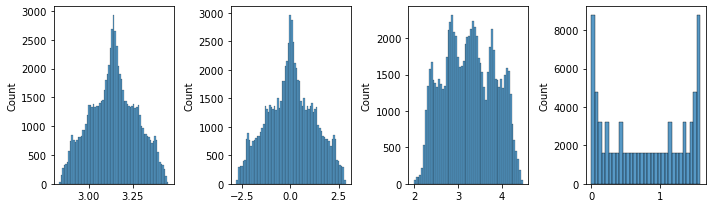

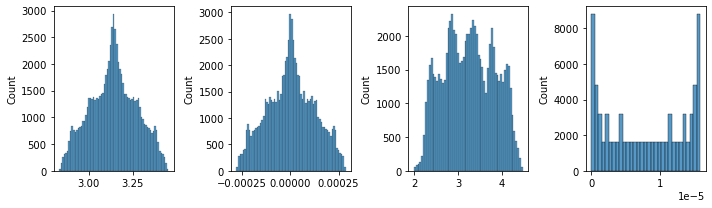

In [4]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'sine' #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2 # 4 # 1.4
u_func.params['scale'] = 0.0001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 100
proportion = 0.0
batch_size = 100
w_rescale = [1, 10000, 1, 100000] # [1, 9000, 1, 10000] # [1,1,1,1]#

# train_loader, test_loader = load_data_device(device, init_method, w_rescale, 
#                                             u_func, g_func, time_steps, 
#                                             shuffle = False, 
#                                             num_trajectories = num_trajectories, 
#                                             coord_type = 'hamiltonian', 
#                                             proportion = proportion, batch_size = batch_size, 
#                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
#                                             g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp) 


# q1, p1, q2, p2, t_eval = get_trajectory_furuta(device, init_method, num_trajectories, u_func, g_func, time_steps, None, noise_std, Ts, C_q1, 
#                           C_q2, g, Jr, Lr, Mp, Lp)
# energy, derivatives = get_energy_furuta(device, time_steps, Ts, u_func, g_func, q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp)

q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta('cpu', init_method, time_steps, num_trajectories, u_func, g_func, 
                          None, Ts,
                          noise_std, C_q1, C_q2, g, 
                          Jr, Lr, Mp, Lp, energ_deriv=True)

# print(u.shape)
# print(G.shape)
print(q1.shape)
print(p1.shape)
print(q2.shape)
print(p2.shape)
print(t_eval.shape)
print(energy.shape)
print(derivatives.shape)
print(1/q1.std(), 1/p1.std(), 1/q2.std(), 1/p2.std())

# w1, w2, w3, w4 = q1.std(), p1.std(), q2.std(), p2.std()
# w_rescale = [1, 10000, 1, 10000]
w1 = w_rescale[0]
w2 = w_rescale[1]
w3 = w_rescale[2]
w4 = w_rescale[3]

fix, ax = plt.subplots(1,4,figsize = (10,3))

sns.histplot(q1.ravel()*w1, ax=ax[0])
sns.histplot(p1.ravel()*w2, ax=ax[1])
sns.histplot(q2.ravel()*w3, ax=ax[2])
sns.histplot(p2.ravel()*w4, ax=ax[3])
plt.tight_layout()
plt.show()

fix, ax = plt.subplots(1,4,figsize = (10,3))
sns.histplot(q1.ravel(), ax=ax[0])
sns.histplot(p1.ravel(), ax=ax[1])
sns.histplot(q2.ravel(), ax=ax[2])
sns.histplot(p2.ravel(), ax=ax[3])
plt.tight_layout()
plt.show()

In [5]:
q1.shape

torch.Size([100, 800])

In [9]:
for x in [q1, p1, q2, p2]:
    x_nominal = x
    maximums = x_nominal.amax(dim=(1))
    minimums = x_nominal.amin(dim=(1))
    denom = (maximums-minimums).abs().unsqueeze(dim=1)

    x_nominal_normalised = (x_nominal-minimums.unsqueeze(dim=1))/denom
    x = x_nominal_normalised

In [10]:
q1 = (q1-q1.amin(dim=(1)).unsqueeze(dim=1))/((q1.amax(dim=(1))-q1.amin(dim=(1))).abs().unsqueeze(dim=1))
q2 = (q2-q2.amin(dim=(1)).unsqueeze(dim=1))/((q2.amax(dim=(1))-q2.amin(dim=(1))).abs().unsqueeze(dim=1))
p1 = (p1-p1.amin(dim=(1)).unsqueeze(dim=1))/((p1.amax(dim=(1))-p1.amin(dim=(1))).abs().unsqueeze(dim=1))
p2 = (p2-p2.amin(dim=(1)).unsqueeze(dim=1))/((p2.amax(dim=(1))-p2.amin(dim=(1))).abs().unsqueeze(dim=1))


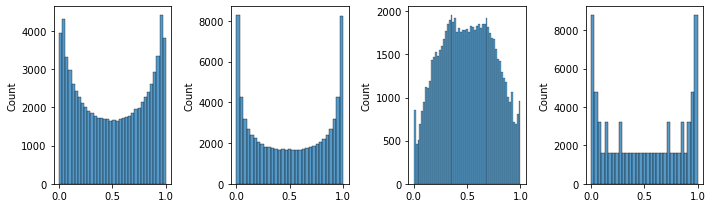

In [11]:
fix, ax = plt.subplots(1,4,figsize = (10,3))

sns.histplot(q1.ravel(), ax=ax[0])
sns.histplot(p1.ravel(), ax=ax[1])
sns.histplot(q2.ravel(), ax=ax[2])
sns.histplot(p2.ravel(), ax=ax[3])
plt.tight_layout()
plt.show()

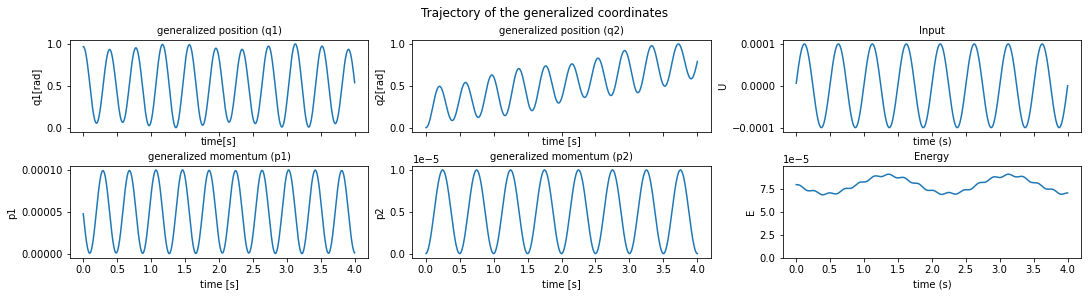

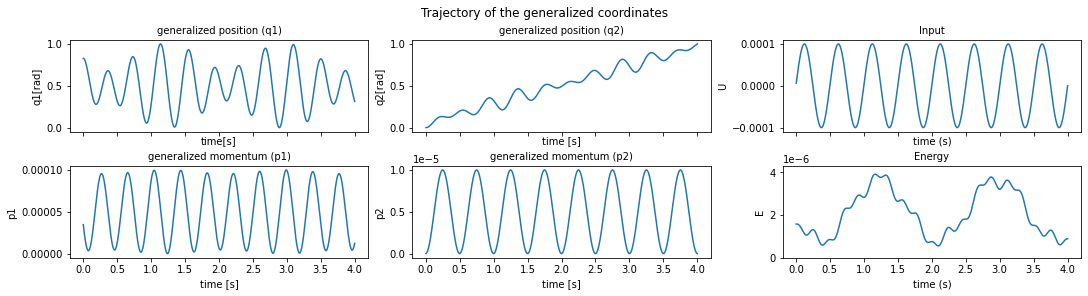

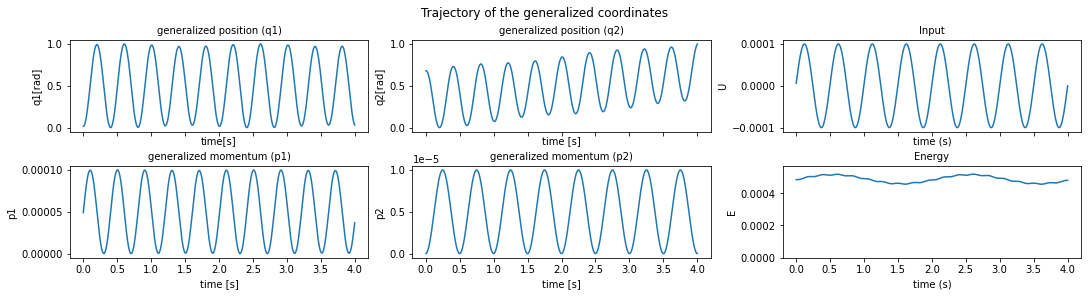

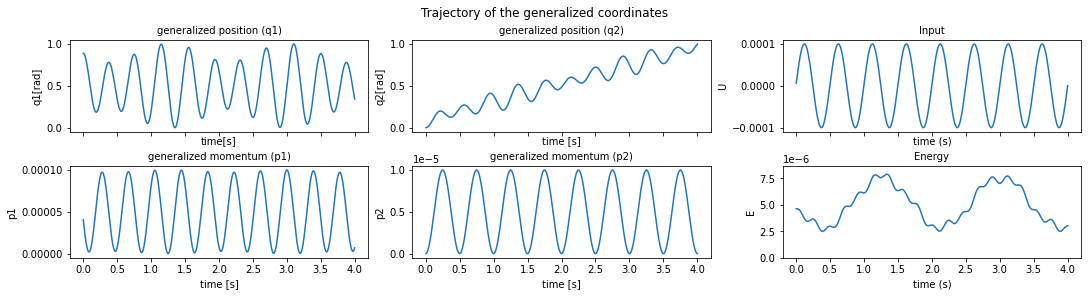

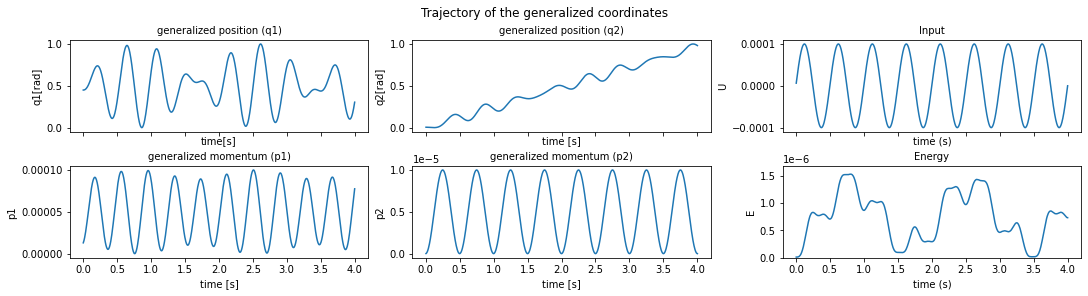

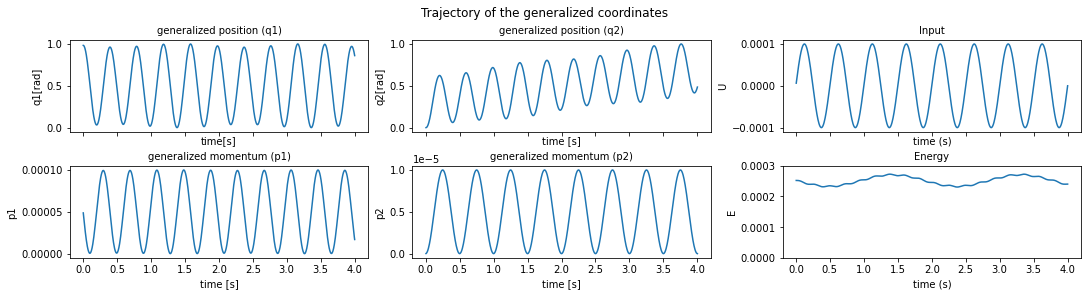

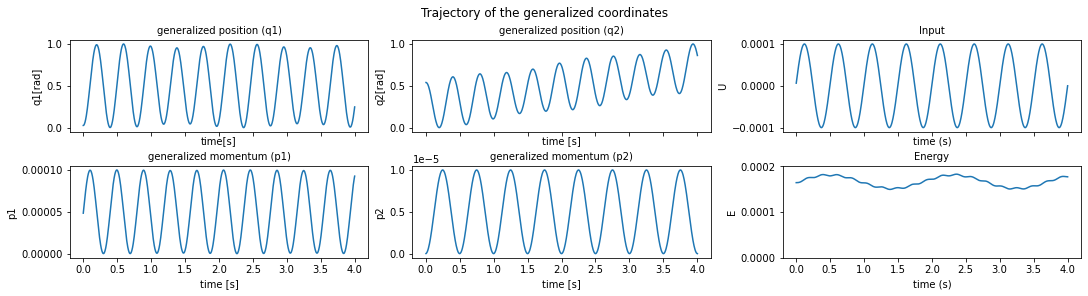

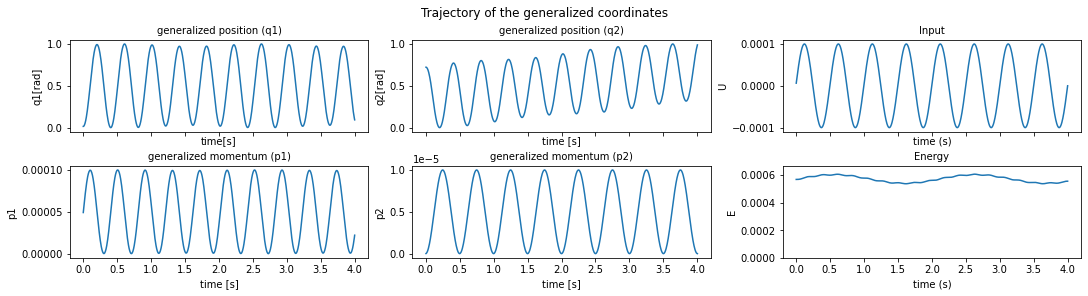

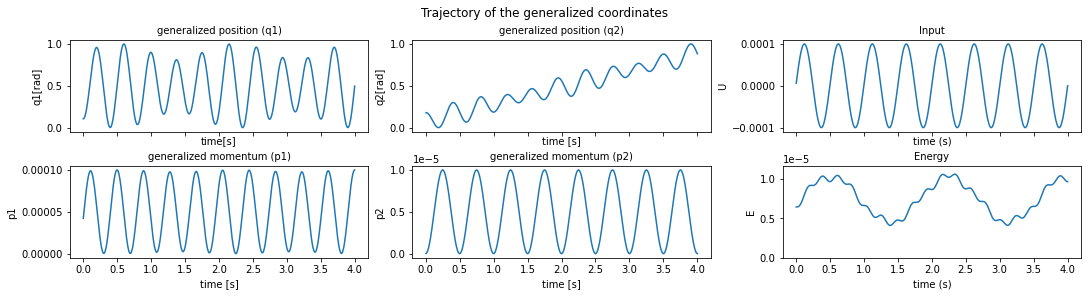

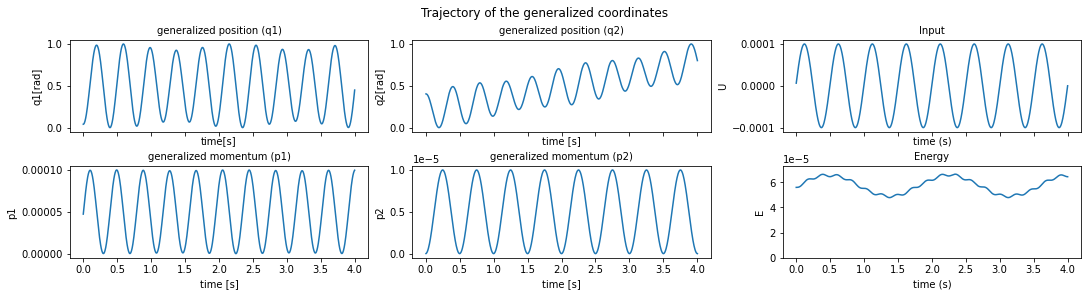

In [12]:
u=u_func.forward(t_eval).cpu().detach() 
for n in range(10): 
   plot_traj_furuta_withinput(t_eval.cpu().detach(), 
   q1[n,:].cpu().detach(), 
   p1[n,:].cpu().detach()/w2, 
   q2[n,:].cpu().detach()/w3, 
   p2[n,:].cpu().detach()/w4, 
   energy = energy[n,:].cpu().detach(), input=u, 
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian') 

In [13]:
batch_size=10

In [14]:
train_loader, test_loader = data_loader_furuta(q1, p1, q2, p2, energy, derivatives, t_eval, batch_size,
                       shuffle = True, proportion = 0.0, coord_type='hamiltonian')

In [15]:
train_loader, test_loader = load_data_device(device, init_method, w_rescale, u_func, g_func, time_steps, num_trajectories, shuffle=False,
                     coord_type='hamiltonian', proportion=proportion, batch_size=batch_size, 
                     Ts = Ts , noise_std = noise_std, C_q1 = C_q1, C_q2 = C_q2, 
                     g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp,min_max_rescale = True)

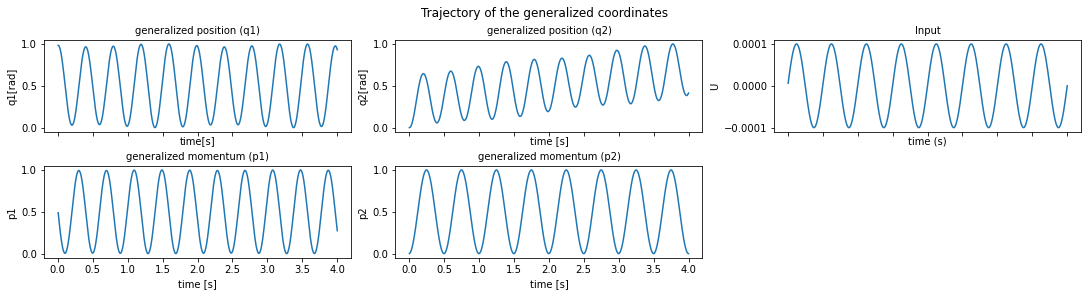

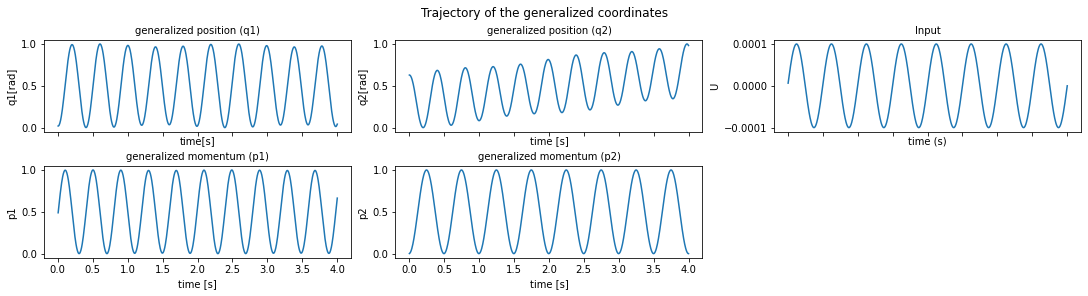

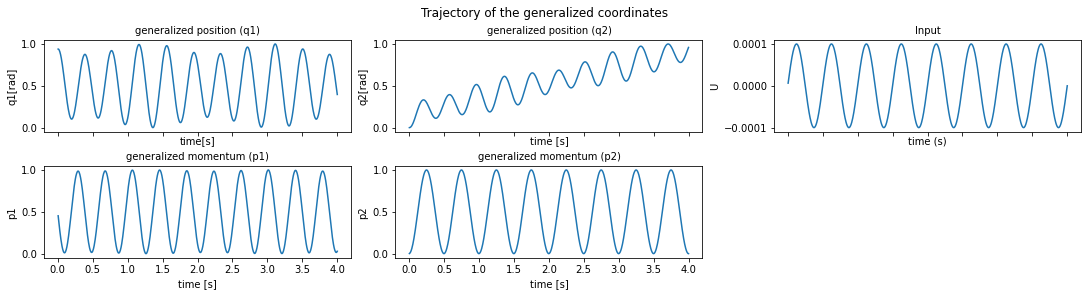

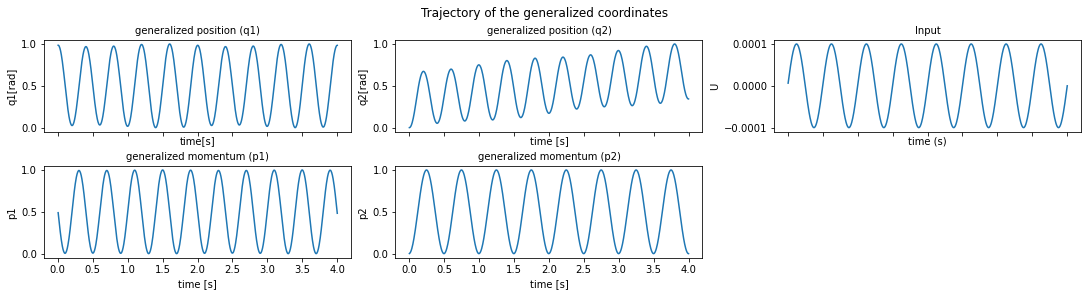

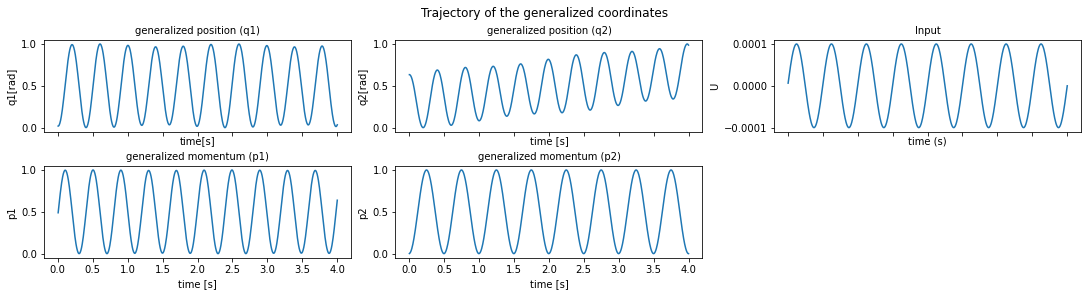

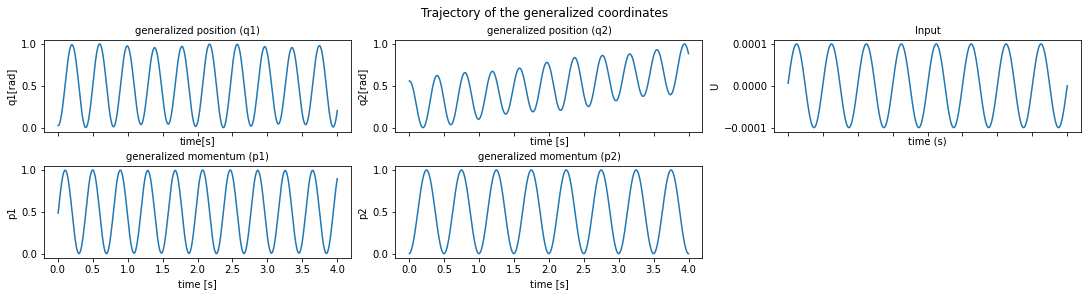

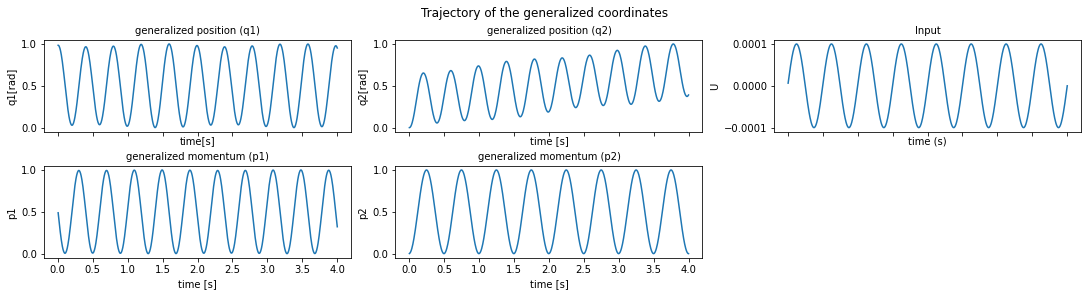

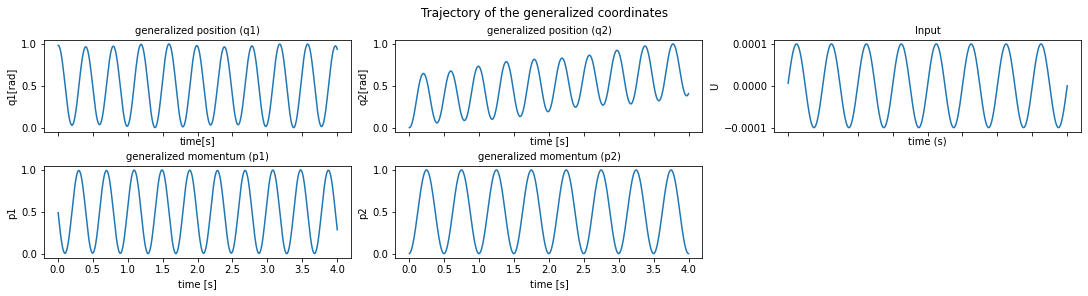

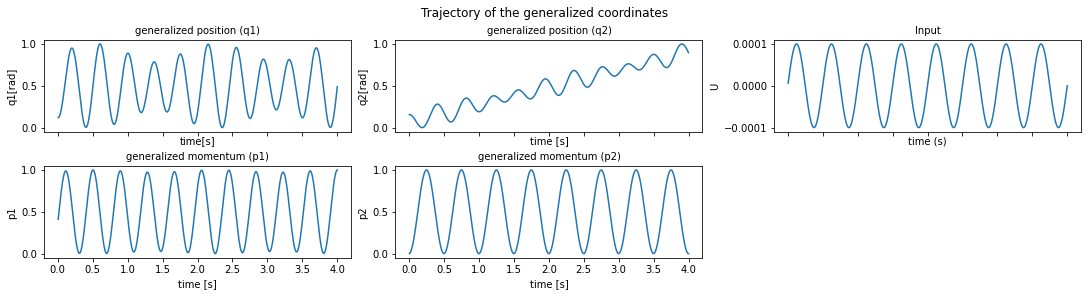

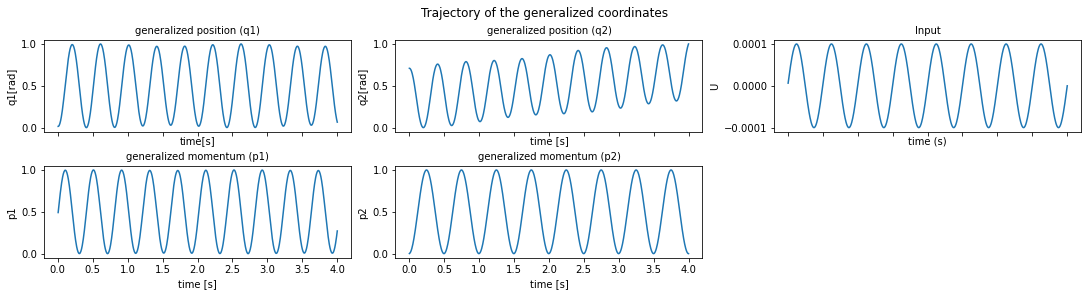

In [16]:
x,t = next(iter(train_loader))
for n in range(10):
  t_eval = t[0,:].cpu().detach()
  q1 = x[n,:,0].cpu().detach()
  p1 = x[n,:,1].cpu().detach()
  q2 = x[n,:,2].cpu().detach()
  p2 = x[n,:,3].cpu().detach()
  u = u_func.forward(t_eval).cpu().detach()
  G = g_func.forward(x[n,:,:4]).cpu().detach()
  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2,input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

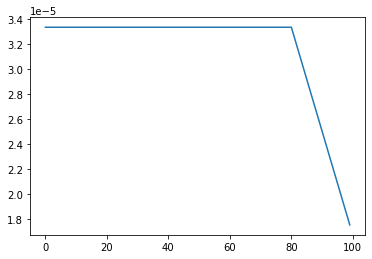

In [17]:
model = torch.nn.Linear(2,1)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4, weight_decay=1e-4)
torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.3333333333333333, end_factor=1.0, total_iters=5, last_epoch=- 1, verbose=False)
max_epochs = 100
begin_decay=80
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=max_epochs-begin_decay)
lrs = []

for epoch in range(max_epochs):
    if epoch>begin_decay:
        optimizer.step()
        scheduler.step()
    lrs.append(scheduler.get_last_lr())
plt.plot(lrs)

# min max normalization

In [ ]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 
# C_q1, C_q2 = 0.000009, 0.00004
utype = 'sine' #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.0001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 125
proportion = 0.0
batch_size = 100
w_rescale = [1, 10000, 1, 100000] # [1, 9000, 1, 10000] # [1,1,1,1]#

In [ ]:
train_loader, test_loader = load_data_device(device, init_method, w_rescale, 
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp) 

In [ ]:
horizon_list = [20, 100, 150,300]

In [ ]:
x,t = next(iter(train_loader))

In [ ]:
for n in range(10):
  t_eval = t[0,:].cpu().detach()
  q1 = x[n,:,0].cpu().detach()
  p1 = x[n,:,1].cpu().detach()
  q2 = x[n,:,2].cpu().detach()
  p2 = x[n,:,3].cpu().detach()
  u = u_func.forward(t_eval).cpu().detach()
  G = g_func.forward(x[n,:,:4]).cpu().detach()
  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2,input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

In [ ]:
fix, ax = plt.subplots(1,4,figsize = (10,3))
print(x.shape)
sns.histplot(x[:,:,0].ravel(), ax=ax[0])
sns.histplot(x[:,:,1].ravel(), ax=ax[1])
sns.histplot(x[:,:,2].ravel(), ax=ax[2])
sns.histplot(x[:,:,3].ravel(), ax=ax[3])
plt.tight_layout()
plt.show()

In [ ]:
i=3
x_nominal = x[:,:,:]

rescale_dims=[1,1,1,1]
dim1, dim2 = (1),(1)
maximums, minimums, denom = get_maxmindenom(x_nominal, dim1, dim2, rescale_dims)

def min_max_rescale_(x, maximums, minimums, denom):
    x_nominal_normalised = (x-minimums)/denom
    return x_nominal_normalised

x_pred_normalised = (x_nominal-minimums)/denom
print(minimums.shape)
print(maximums.shape)
print(denom.shape)
print(x_nominal.shape)
print(x_pred_normalised.shape)

In [ ]:
fix, ax = plt.subplots(1,4,figsize = (10,3))

sns.histplot(x_pred_normalised[:,:,0].ravel(), ax=ax[0])
sns.histplot(x_pred_normalised[:,:,1].ravel(), ax=ax[1])
sns.histplot(x_pred_normalised[:,:,2].ravel(), ax=ax[2])
sns.histplot(x_pred_normalised[:,:,3].ravel(), ax=ax[3])
plt.tight_layout()
plt.show()

In [ ]:
for n in range(10):
  t_eval = t[0,:horizon_list[i]].cpu().detach()
  q1 = x_pred_normalised[n,:,0].cpu().detach()
  p1 = x_pred_normalised[n,:,1].cpu().detach()
  q2 = x_pred_normalised[n,:,2].cpu().detach()
  p2 = x_pred_normalised[n,:,3].cpu().detach()
  u = u_func.forward(t_eval).cpu().detach()
  G = g_func.forward(x[n,:,:4]).cpu().detach()
  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2,input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

In [ ]:
# print((b).shape)

# plt.subplots(sns.histplot((b[:,:,0]).ravel(),ax=ax[0]))
# plt.subplots(sns.histplot((b[:,:,1]).ravel(),ax=ax[1]))
# plt.subplots(sns.histplot((b[:,:,2]).ravel(),ax=ax[2]))
# plt.subplots(sns.histplot((b[:,:,3]).ravel(),ax=ax[3]))

# test

In [14]:
os.getcwd()

'c:\\Users\\Younes\\Documents\\GitHub\\SP-learning-hamiltonian-functions-from-data\\furuta_pendulum\\notebooks'

In [16]:
%cd ..

c:\Users\Younes\Documents\GitHub\SP-learning-hamiltonian-functions-from-data\furuta_pendulum


In [17]:
%load src/data.py

# test 2

In [6]:
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800 
num_trajectories = 125 
proportion = 0.8 # train test proportion
batch_size = 100
w_rescale = [1, 1000, 1, 10000]  #[1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False
coord_type = 'newtonian'
rescale_dims = [1, 1, 1, 0]
min_max_rescale = False

### Parameters for the training procedure
resnet_config = None # 
alternating = False # for Input_HNN, if G is a neural network, train 
horizon_type = 'auto' # 'auto' or 'constant'
horizon = False # if horizon_type == 'constant', use this horizon
loss_type = 'L2' # 'L2' or 'L2weighted' 
collect_grads = False # collect gradients in all layers at every epoch
rescale_loss = True # rescale the difference between nominal and train by the min max of train trajectory in loss function
grad_clip = False  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

cpu


In [7]:
x,t = next(iter(train_loader))

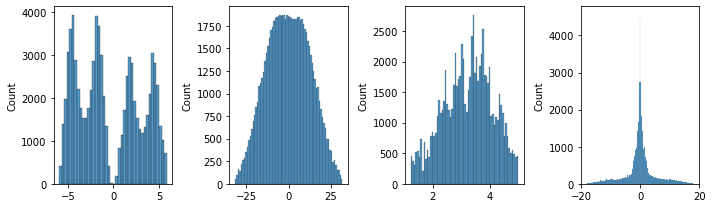

In [8]:
fix, ax = plt.subplots(1,4,figsize = (10,3))

sns.histplot(x[:,:,0].ravel(), ax=ax[0])
sns.histplot(x[:,:,1].ravel(), ax=ax[1])
sns.histplot(x[:,:,2].ravel(), ax=ax[2])
sns.histplot(x[:,:,3].ravel(), ax=ax[3])
plt.tight_layout()
plt.show()

In [9]:
print(x.shape)

torch.Size([100, 800, 4])


In [10]:
print(x.shape)

torch.Size([100, 800, 4])


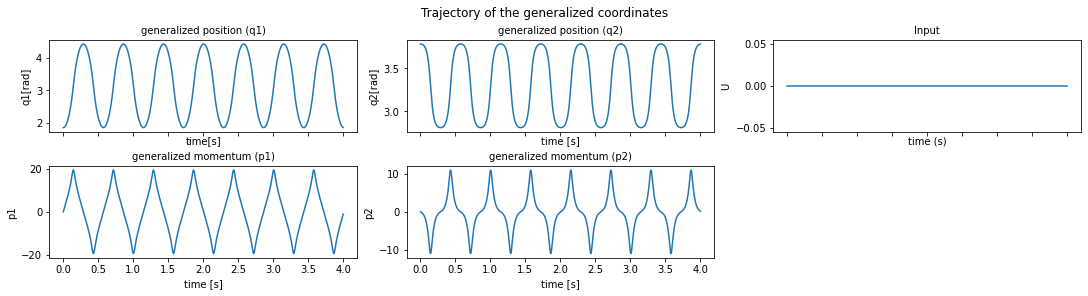

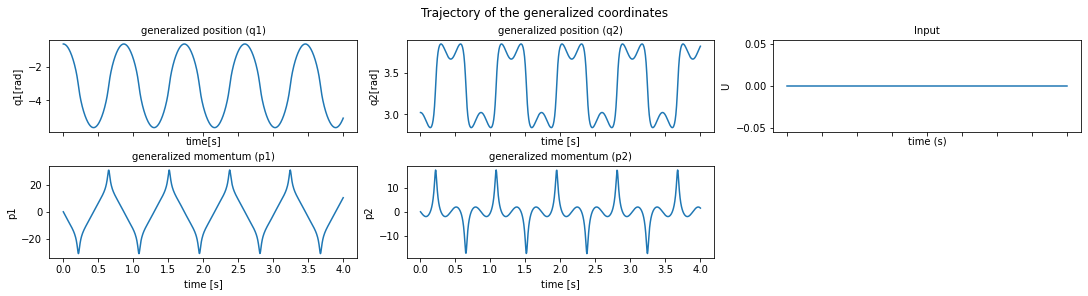

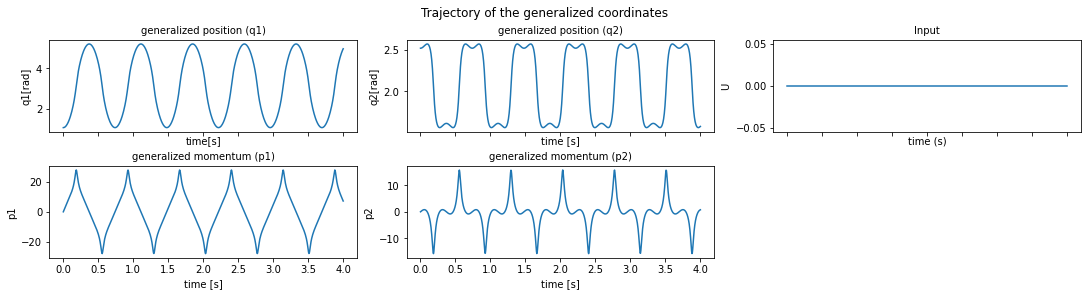

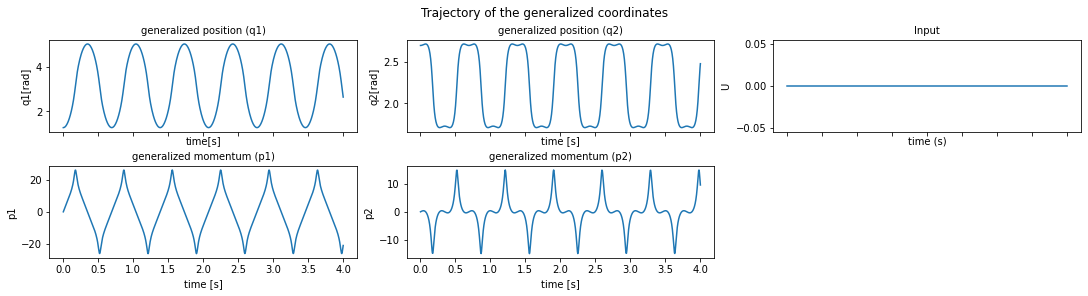

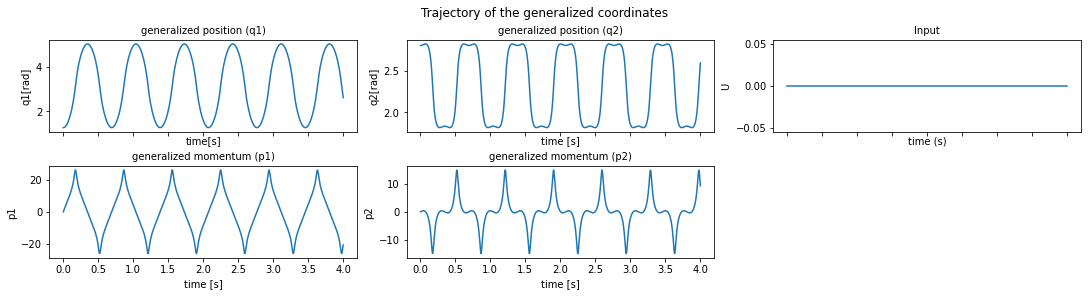

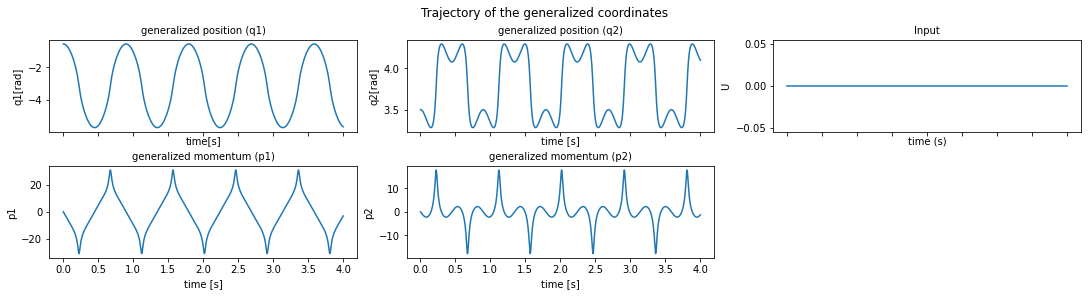

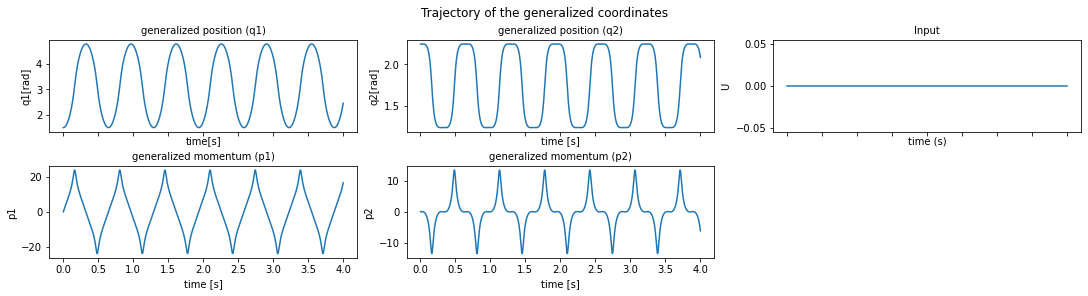

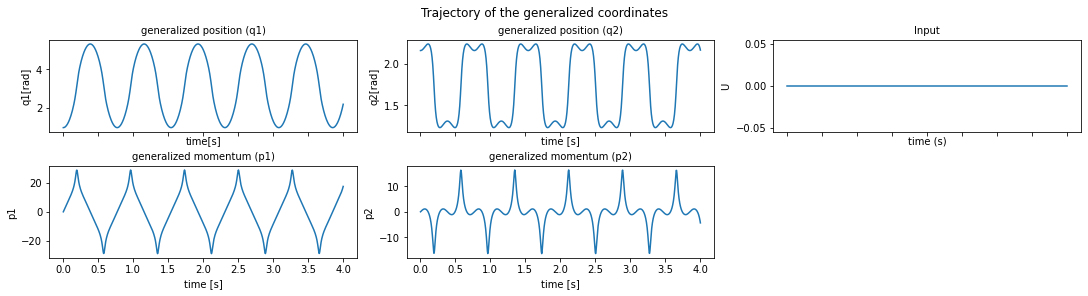

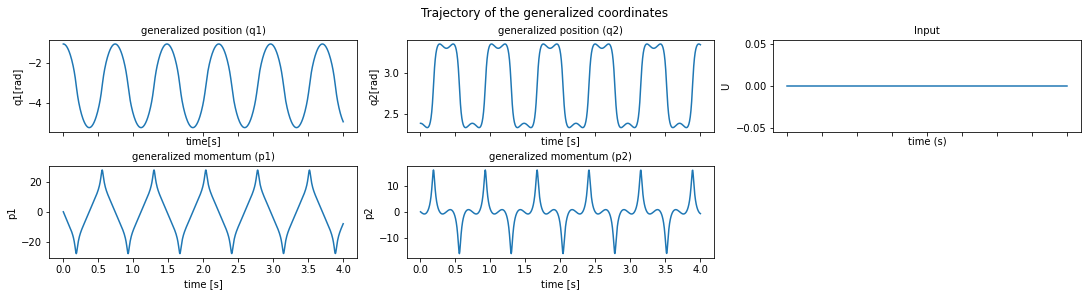

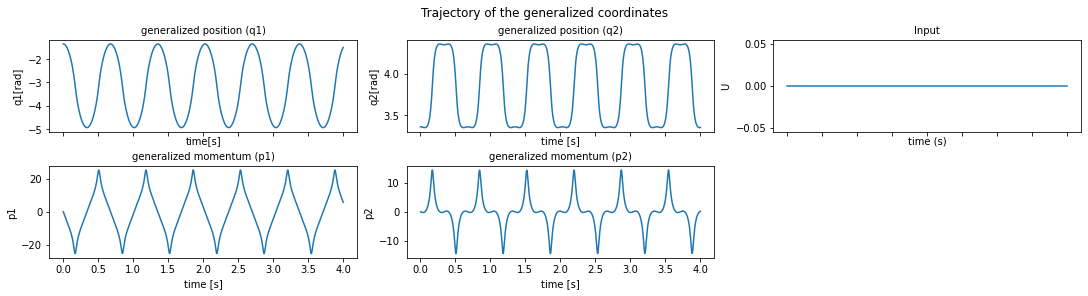

In [11]:
for n in range(10):
  t_eval = t[0,:].cpu().detach()
  q1 = x[n,:,0].cpu().detach()
  p1 = x[n,:,1].cpu().detach()
  q2 = x[n,:,2].cpu().detach()
  p2 = x[n,:,3].cpu().detach()
  u = u_func.forward(t_eval).cpu().detach()
  G = g_func.forward(x[n,:,:4]).cpu().detach()
  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2,input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

# Generate, load and save the dataset

In [ ]:
device = set_device()
furuta_type = 'real' # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = furuta_type) 

utype = None #  'chirp' or None or '' or ''
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 4 # 4 # 1.4
u_func.params['scale'] = 0.001 # for fake : 0.5 or 0.1 for real : 0.0001
gtype='simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero' # 'random_nozero' # 'random_closetopi'
time_steps= 300
num_trajectories = 10
proportion = 0.0
batch_size = 100
w_rescale = [1, 1000, 1, 10000] # [1, 9000, 1, 10000]

train_loader, test_loader = load_data_device(device, init_method, w_rescale, 
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = proportion, batch_size = batch_size, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp) 

In [ ]:
x,t = next(iter(train_loader))
print(x.shape)
for n in range(1):
  t_eval = t[0,:].cpu().detach()
  q1 = x[n,:,0].cpu().detach()
  p1 = x[n,:,1].cpu().detach()
  q2 = x[n,:,2].cpu().detach()
  p2 = x[n,:,3].cpu().detach()
  
  u = u_func.forward(t_eval).cpu().detach()
  G = g_func.forward(x[n,:,:4]).cpu().detach()
  energy, derivatives = get_energy_furuta(device, time_steps, Ts, u_func, g_func, 
  q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
  print('q1',q1.shape)
  print('energy',energy.shape)
  energy = energy.detach().squeeze()

  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2, energy=energy, input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')